# Validating Efficient Methods for Measuring Intertemporal Choice

### A Methodological Comparison of Two Procedures for Assessing Delayed Losses

This Jupyter Notebook provides a complete Python-based replication of the analyses from the publication:

> Wan, H., Green, L., & Myerson, J. (2024). Delayed monetary losses: Do different procedures and measures assess the same construct?. *Behavioural Processes, 222*, 105101. https://doi.org/10.1016/j.beproc.2024.105101

#### Project Objective
The goal of this study is **methodological validation**. It formally tests whether a brief, 27-item survey (the Delayed Losses Questionnaire, DLQ) yields a valid and reliable measure of delay discounting when compared to the more resource-intensive Adjusting-Amount (Adj-Amt) procedure.

#### Analysis Workflow
1.  **Setup**: Imports all necessary Python libraries and defines custom functions.
2.  **Data Processing**: Cleans and transforms the raw data, calculating the four key discounting measures.
3.  **Group-Level Analysis**: Visualizes aggregate choice patterns (Figure 1 replication) and fits non-linear models to assess data quality.
4.  **Reliability & Validity Analysis**: Assesses the reliability of measures within each procedure and the convergent validity between them.
5.  **Choice Pattern Analysis**: Categorizes and compares individual response styles across procedures.

The data are publicly available on the Open Science Framework: <https://osf.io/emb2q/>.

In [7]:
# --- 1. Environment Setup ---
# This cell installs all the required Python packages.
# It is commented out by default. Uncomment and run if the packages are not yet installed.

# import sys
# !{sys.executable} -m pip install pandas numpy scipy lmfit statsmodels seaborn scikit-learn pingouin

In [8]:
# --- 1. SETUP: IMPORTS AND CUSTOM FUNCTIONS ---

# --- Core Libraries ---
import pandas as pd
import numpy as np
import warnings
from scipy.optimize import curve_fit
from scipy.stats import gmean, chi2_contingency
import openpyxl # Required for reading Excel files with pandas

# --- Statistics and Modeling ---
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pingouin import anova

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global Settings ---
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

# --- Custom Functions ---

def set_plot_theme(ax, title="", xlabel="", ylabel=""):
    """
    Applies a consistent, publication-quality theme to a Matplotlib axes object,
    mimicking the R mattheme function.
    """
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold', labelpad=10)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    ax.set_facecolor('white')
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10, direction='in')
    if ax.get_legend():
        ax.legend(frameon=False, title_fontproperties={'weight':'bold', 'size': 12})

## Data Processing

The raw data is loaded, filtered to the final sample (N = 431), and then transformed to calculate the four primary discounting scores:
- **For the Adj-Amt procedure**:
    1. `auc_adj_amt`: Area Under the Curve (atheoretical).
    2. `logk_adj_amt`: The log-transformed *k* parameter from a simple hyperbolic model (theoretical).
- **For the DLQ procedure**:
    1. `prop_imm_dlq`: The proportion of immediate choices (atheoretical).
    2. `logk_dlq`: The log-transformed *k* parameter estimated from the choice pattern (theoretical).

In [9]:
# --- 2. DATA LOADING AND PROCESSING ---

# --- Load and Clean Raw Data from Excel ---
adj_amt_df_raw = pd.read_excel("Data_AdjAmt_DLQ.xlsx", sheet_name=0).rename(
    columns={'Participant Number': 'ID', 'Delay (months)': 'Delay'}
)
adj_amt_df_raw['Amount'] = adj_amt_df_raw['Amount'].map({90: "$90", 240: "$240", 1500: "$1,500"})
adj_amt_df_raw['Procedure'] = "Adj-Amt"

dlq_df_raw = pd.read_excel("Data_AdjAmt_DLQ.xlsx", sheet_name=1).rename(
    columns={'Participant Number': 'ID', 'Question Number': 'Q_ID'}
)
dlq_df_raw['Procedure'] = "DLQ"

# --- Calculate Scores for the Adjusting-Amount (Adj-Amt) Procedure ---
def calculate_adj_amt_scores(group):
    """Calculates AuC and log(k) for one participant's Adj-Amt data."""
    auc = np.trapz(y=group['RSV'], x=group['Delay'] / 108)
    def hyperbola(delay, k): return 1 / (1 + k * delay)
    try:
        params, _ = curve_fit(hyperbola, group['Delay'], group['RSV'], p0=[0.01])
        logk = np.log(params[0]) if params[0] > 0 else np.nan
    except (RuntimeError, ValueError):
        logk = np.nan
    return pd.Series({'auc_adj_amt': auc, 'logk_adj_amt': logk})

adj_amt_scores = adj_amt_df_raw.groupby(['Procedure', 'ID', 'Amount']).apply(calculate_adj_amt_scores).reset_index()

# --- Create DLQ Item Parameter Lookup Table ---
dlq_item_parameters = pd.DataFrame({
    'Q_ID': range(1, 28),
    'k': [0.014000, 0.000057, 0.000880, 0.000057, 0.001800, 0.000140, 0.000880, 0.000022, 
          0.005900, 0.000890, 0.000022, 0.000140, 0.000140, 0.002300, 0.000009, 0.000057,
          0.014000, 0.000340, 0.000009, 0.005800, 0.005500, 0.000022, 0.002300, 0.014000, 
          0.000340, 0.000340, 0.000009],
    'Amount_raw': ["$165", "$75", "$240", "$180", "$225", "$90", "$150", "$90", "$240", 
                   "$105", "$255", "$180", "$255", "$150", "$105", "$225", "$90", "$165", 
                   "$240", "$180", "$105", "$150", "$75", "$255", "$75", "$225", "$165"]
})
# Group amounts into blocks consistent with the paper's analysis
dlq_item_parameters['Amount'] = pd.cut(
    dlq_item_parameters['Amount_raw'].str.replace('$', '', regex=False).astype(int),
    bins=[0, 105, 180, 255],
    labels=["$90", "$165", "$240"]
)

# --- Calculate Scores for the Delayed Losses Questionnaire (DLQ) ---
dlq_data_merged = pd.merge(dlq_df_raw, dlq_item_parameters.drop(columns='Amount_raw'), on='Q_ID')
k_remap = {0.00088: 0.00089, 0.00180: 0.00230, 0.0058: 0.00550, 0.0059: 0.00550}
dlq_data_merged['k'] = dlq_data_merged['k'].replace(k_remap)

def calculate_dlq_scores(group):
    """Calculates proportion of immediate choices and log(k) for DLQ data."""
    prop_immediate = group['Choice'].mean()
    choices, k_values = group['Choice'].values, group['k'].values
    if all(choices == 1): logk = np.log(k_values.min())
    elif all(choices == 0): logk = np.log(k_values.max())
    else:
        n_consistent = [sum((choices == 0) & (k_values <= k) | (choices == 1) & (k_values >= k)) for k in k_values]
        indifference_ks = k_values[np.where(n_consistent == np.max(n_consistent))]
        logk = np.log(gmean(indifference_ks))
    return pd.Series({'prop_imm_dlq': prop_immediate, 'logk_dlq': logk})

dlq_scores = dlq_data_merged.groupby(['Procedure', 'ID', 'Amount']).apply(calculate_dlq_scores).reset_index()

# --- Classify Individual Choice Patterns ---

def summarize_adj_amt_group(g):
    return pd.Series({
        'correlation': g['RSV'].corr(np.log(g['Delay'])),
        'mean_sv': g['RSV'].mean()
    })

# Get global min/max values for classification
min_rsv = adj_amt_df_raw['RSV'].min()
max_rsv = adj_amt_df_raw['RSV'].max()

def classify_adj_amt_pattern(row):
    if row['correlation'] < 0 or np.isclose(row['mean_sv'], min_rsv):
        return "Typical"
    if row['correlation'] > 0:
        return "Atypical"
    if np.isclose(row['mean_sv'], max_rsv):
        return "Always immediate"
    return "Typical"

# Chain the operations to mirror the R pipe
adj_amt_patterns_raw = (
    adj_amt_df_raw[adj_amt_df_raw['Amount'] != '$1,500']
    .groupby(['ID', 'Amount'])
    .apply(summarize_adj_amt_group)
    .reset_index()
    .fillna({'correlation': 0}) 
)
adj_amt_patterns_raw['pattern'] = adj_amt_patterns_raw.apply(classify_adj_amt_pattern, axis=1)

# Summarize consistency for each ID
adj_amt_patterns = (
    adj_amt_patterns_raw.groupby('ID')['pattern']
    .apply(lambda g: g.iloc[0] if g.nunique() == 1 else "Inconsistent")
    .reset_index(name='pattern_adj_amt')
)

def summarize_dlq_group(g):
    return pd.Series({
        'correlation': g['Choice'].corr(np.log(g['k'])),
        'mean_choice': g['Choice'].mean()
    })

def classify_dlq_pattern(row):
    if row['correlation'] > 0 or np.isclose(row['mean_choice'], 0):
        return "Typical"
    if row['correlation'] < 0:
        return "Atypical"
    if np.isclose(row['mean_choice'], 1):
        return "Always immediate"
    return np.nan

# Chain the operations to mirror the R pipe
dlq_patterns_raw = (
    dlq_data_merged[dlq_data_merged['Amount'] != '$165']
    .groupby(['ID', 'Amount'])
    .apply(summarize_dlq_group)
    .reset_index()
    .fillna({'correlation': 0}) 
)
dlq_patterns_raw['pattern'] = dlq_patterns_raw.apply(classify_dlq_pattern, axis=1)

# Summarize consistency for each ID.
dlq_patterns = (
    dlq_patterns_raw.groupby('ID')['pattern']
    .apply(lambda g: g.iloc[0] if g.nunique() == 1 else "Inconsistent")
    .reset_index(name='pattern_dlq')
)

# --- 3. Join the Results ---
pattern_consistency = pd.merge(adj_amt_patterns, dlq_patterns, on="ID", how="outer")

## Group-Level Analysis

This section replicates Figure 1 from the publication, visualizing the aggregate discounting patterns for both procedures. The plots confirm that the data conform to established findings, and goodness-of-fit statistics confirm that the chosen non-linear models describe the data well.

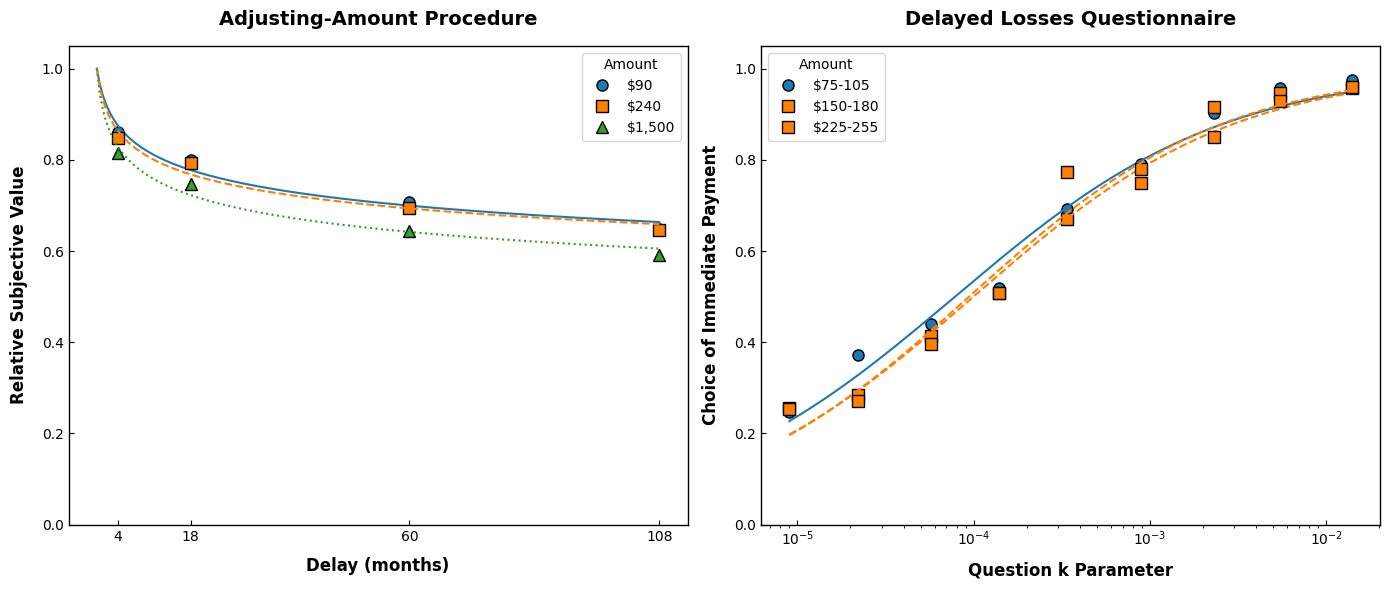


--- Adj-Amt: R-squared for Hyperboloid Fits ---
        R-squared
Amount           
$90         0.962
$240        0.957
$1,500      0.965

--- DLQ: R-squared for Logistic Fits ---
        R-squared
Amount           
$90         0.984
$165        0.983
$240        0.975


In [10]:
# --- 3. GROUP-LEVEL ANALYSIS (FIGURE 1 REPLICATION) ---

# --- Prepare Group-Level Data ---
# Create aggregated dataframes for each procedure, mirroring the R script
adj_amt_group_level = adj_amt_df_raw.groupby(['Amount', 'Delay']).agg(
    mean_RSV=('RSV', 'mean')
).reset_index()
adj_amt_group_level['Amount'] = pd.Categorical(adj_amt_group_level['Amount'], 
                                               categories=["$90", "$240", "$1,500"], ordered=True)

dlq_group_level = dlq_data_merged.groupby(['Amount', 'k']).agg(
    Prop=('Choice', 'mean')
).reset_index()
dlq_group_level['Amount'] = pd.Categorical(dlq_group_level['Amount'], 
                                           categories=["$90", "$165", "$240"], ordered=True)

# --- Define Nonlinear Model Functions ---
def hyperboloid_func(x, k, s):
    """Hyperboloid discounting function for group-level Adj-Amt data."""
    return 1 / (1 + np.exp(k) * x)**s

def logistic_func(x, a, r):
    """Logistic growth function for group-level DLQ data."""
    return 1 / (1 + np.exp(-(x - a) * r))

# --- Create Plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = {"$90": "#1f78b4", "$240": "#ff7f00", "$1,500": "#33a02c", 
          "$165": "#ff7f00"}
shapes = {"$90": "o", "$240": "s", "$1,500": "^", "$165": "s"}
linestyles = {"$90": "solid", "$240": "dashed", "$1,500": "dotted", "$165": "dashed"}

# --- Panel 1: Adjusting-Amount Procedure ---
for amount, group in adj_amt_group_level.groupby('Amount'):
    # Plot raw data points
    axes[0].plot(group['Delay'], group['mean_RSV'], marker=shapes[amount], linestyle='', 
                 color=colors[amount], label=amount, markersize=8, markerfacecolor=colors[amount], markeredgecolor='black')
    
    # Fit and plot hyperboloid curve
    try:
        popt, _ = curve_fit(hyperboloid_func, group['Delay'], group['mean_RSV'], p0=[-4, 1])
        x_pred = np.linspace(0, 108, 200)
        axes[0].plot(x_pred, hyperboloid_func(x_pred, *popt), color=colors[amount], linestyle=linestyles[amount], lw=1.5)
    except RuntimeError:
        print(f"Could not fit curve for Adj-Amt Amount: {amount}")

set_plot_theme(axes[0], title="Adjusting-Amount Procedure", xlabel="Delay (months)", ylabel="Relative Subjective Value")
axes[0].set_ylim(0, 1.05)
axes[0].set_xticks([4, 18, 60, 108])
axes[0].legend(title="Amount")

# --- Panel 2: Delayed Losses Questionnaire ---
dlq_labels = {"$90": "$75-105", "$165": "$150-180", "$240": "$225-255"}
dlq_group_level['Amount_Label'] = dlq_group_level['Amount'].map(dlq_labels)
dlq_group_level['log_k'] = np.log(dlq_group_level['k'])

for amount_label, group in dlq_group_level.groupby('Amount_Label'):
    amount_orig = [k for k, v in dlq_labels.items() if v == amount_label][0]
    # Plot raw data points
    axes[1].plot(group['k'], group['Prop'], marker=shapes[amount_orig], linestyle='',
                 color=colors[amount_orig], label=amount_label, markersize=8, markerfacecolor=colors[amount_orig], markeredgecolor='black')
    
    # Fit and plot logistic curve
    try:
        popt, _ = curve_fit(logistic_func, group['log_k'], group['Prop'], p0=[-9.3, 0.58], maxfev=5000)
        x_pred_log = np.linspace(group['log_k'].min(), group['log_k'].max(), 200)
        axes[1].plot(np.exp(x_pred_log), logistic_func(x_pred_log, *popt), color=colors[amount_orig], linestyle=linestyles[amount_orig], lw=1.5)
    except RuntimeError:
        print(f"Could not fit curve for DLQ Amount: {amount_label}")

set_plot_theme(axes[1], title="Delayed Losses Questionnaire", xlabel="Question k Parameter", ylabel="Choice of Immediate Payment")
axes[1].set_xscale('log')
axes[1].set_ylim(0, 1.05)
axes[1].legend(title="Amount")

plt.tight_layout()
plt.show()

# --- Goodness-of-Fit (R-squared) for Group-Level Models ---
from sklearn.metrics import r2_score

print("\n--- Adj-Amt: R-squared for Hyperboloid Fits ---")
adj_amt_r2 = adj_amt_group_level.groupby('Amount').apply(
    lambda g: r2_score(g['mean_RSV'], hyperboloid_func(g['Delay'], *curve_fit(hyperboloid_func, g['Delay'], g['mean_RSV'], p0=[-4, 1])[0]))
)
print(adj_amt_r2.rename("R-squared").to_frame())

print("\n--- DLQ: R-squared for Logistic Fits ---")
dlq_r2 = dlq_group_level.groupby('Amount').apply(
    lambda g: r2_score(g['Prop'], logistic_func(g['log_k'], *curve_fit(logistic_func, g['log_k'], g['Prop'], p0=[-10, 1], maxfev=5000)[0]))
)
print(dlq_r2.rename("R-squared").to_frame())

## Reliability and Validity Analysis

This section replicates the core psychometric analyses from the paper, focusing on the internal consistency and measurement properties of the Adj-Amt and DLQ procedures.

### Within-Procedure Reliability (Alternate-Forms)
First, we assess **reliability** by examining the correlations between different loss amounts *within* each procedure. High correlations indicate that the procedure consistently measures the same construct regardless of the specific monetary amounts used.

### Within-Procedure Concurrent Validity
Next, we test **concurrent validity** by examining the correlations between the atheoretical (e.g., `auc_adj_amt`) and theoretical (`logk_adj_amt`) measures derived from the *same* procedure. High positive correlations would confirm that both scoring methods are capturing the same underlying information about a participant's choice behavior.

In [11]:
# --- 4. RELIABILITY AND VALIDITY ANALYSIS ---

# --- 4.1 Within-Procedure Reliability (Alternate-Forms) ---
# This assesses if the measures are consistent across different loss amounts.

print("--- Reliability: Correlations Between Amounts Within Adjusting-Amount Procedure ---")
# Pivot to create a wide dataframe for correlation
adj_amt_reliability_wide = adj_amt_scores.pivot(index='ID', columns='Amount', 
                                                values=['auc_adj_amt', 'logk_adj_amt'])

# Calculate and display the correlation matrix for the atheoretical (AuC) measure
print("\nAtheoretical (AuC) Correlations:")
auc_reliability_adj_amt = adj_amt_reliability_wide['auc_adj_amt'].corr()
display(auc_reliability_adj_amt)

# Calculate and display the correlation matrix for the theoretical (log k) measure
print("\nTheoretical (log k) Correlations:")
logk_reliability_adj_amt = adj_amt_reliability_wide['logk_adj_amt'].corr()
display(logk_reliability_adj_amt)


print("\n\n--- Reliability: Correlations Between Amounts Within DLQ ---")
# Pivot to create a wide dataframe for correlation
dlq_reliability_wide = dlq_scores.pivot(index='ID', columns='Amount', 
                                        values=['prop_imm_dlq', 'logk_dlq'])

# Calculate and display the correlation matrix for the atheoretical (proportion) measure
print("\nAtheoretical (Proportion Immediate) Correlations:")
prop_reliability_dlq = dlq_reliability_wide['prop_imm_dlq'].corr()
display(prop_reliability_dlq)

# Calculate and display the correlation matrix for the theoretical (log k) measure
print("\nTheoretical (log k) Correlations:")
logk_reliability_dlq = dlq_reliability_wide['logk_dlq'].corr()
display(logk_reliability_dlq)


# --- 4.2 Within-Procedure Concurrent Validity ---
# This assesses if the atheoretical and theoretical measures capture the same information.
# The correlation should be high and positive, as higher AuC/prop_imm and higher logk 
# both indicate steeper discounting for losses.

print("\n\n--- Concurrent Validity: Correlations Between Atheoretical and Theoretical Measures ---")
adj_amt_concurrent_validity = adj_amt_scores.groupby('Amount').apply(
    lambda g: g['auc_adj_amt'].corr(g['logk_adj_amt'])
).rename('Adj_Amt_Corr').to_frame()
display(adj_amt_concurrent_validity)

dlq_concurrent_validity = dlq_scores.groupby('Amount').apply(
    lambda g: g['prop_imm_dlq'].corr(g['logk_dlq'])
).rename('DLQ_Corr').to_frame()
display(dlq_concurrent_validity)

--- Reliability: Correlations Between Amounts Within Adjusting-Amount Procedure ---

Atheoretical (AuC) Correlations:


Amount,"$1,500",$240,$90
Amount,,,
"$1,500",1.000,0.763,0.636
$240,0.763,1.000,0.782
$90,0.636,0.782,1.000



Theoretical (log k) Correlations:


Amount,"$1,500",$240,$90
Amount,,,
"$1,500",1.000,0.763,0.627
$240,0.763,1.000,0.797
$90,0.627,0.797,1.000




--- Reliability: Correlations Between Amounts Within DLQ ---

Atheoretical (Proportion Immediate) Correlations:


Amount,$90,$165,$240
Amount,,,
$90,1.000,0.866,0.806
$165,0.866,1.000,0.893
$240,0.806,0.893,1.000



Theoretical (log k) Correlations:


Amount,$90,$165,$240
Amount,,,
$90,1.000,0.836,0.746
$165,0.836,1.000,0.840
$240,0.746,0.840,1.000




--- Concurrent Validity: Correlations Between Atheoretical and Theoretical Measures ---


,Adj_Amt_Corr
Amount,
"$1,500",-0.967
$240,-0.968
$90,-0.960


,DLQ_Corr
Amount,
$90,-0.981
$165,-0.982
$240,-0.977


## Analysis of Choice Patterns

Finally, this section examines whether individuals show consistent *qualitative* patterns of choice across the two procedures. While the correlation analysis assesses the relationship between quantitative scores, this analysis tests whether a participant's categorical response style (e.g., "Typical," "Always immediate") on one procedure is significantly associated with their style on the other.

1.  **Pattern Frequencies**: First, we calculate the proportion of participants falling into each response pattern category for both the Adj-Amt and DLQ procedures.
2.  **Contingency Analysis**: Next, we create a cross-tabulation (contingency table) to observe the joint distribution of these patterns.
3.  **Chi-Squared Test**: Finally, we perform a Chi-Squared test of independence to formally test whether there is a statistically significant association between the choice patterns exhibited on the two procedures.

In [12]:
# --- 2.2 Classify Individual Choice Patterns ---

# --- 1. Translate Adj-Amt Pattern Classification ---

def summarize_adj_amt_group(g):
    return pd.Series({
        'correlation': g['RSV'].corr(np.log(g['Delay'])),
        'mean_sv': g['RSV'].mean()
    })

# Get global min/max values for classification
min_rsv = adj_amt_df_raw['RSV'].min()
max_rsv = adj_amt_df_raw['RSV'].max()

# Classification logic mimicking R's `case_when` for Adj-Amt
def classify_adj_amt_pattern(row):
    if row['correlation'] < 0 or np.isclose(row['mean_sv'], min_rsv):
        return "Typical"
    if row['correlation'] > 0:
        return "Atypical"
    if np.isclose(row['mean_sv'], max_rsv):
        return "Always immediate"
    return "Typical"

# Chain the operations to mirror the R pipe
adj_amt_patterns_raw = (
    adj_amt_df_raw[adj_amt_df_raw['Amount'] != '$1,500'] 
    .groupby(['ID', 'Amount'])
    .apply(summarize_adj_amt_group) 
    .reset_index()
    .fillna({'correlation': 0})
)
adj_amt_patterns_raw['pattern'] = adj_amt_patterns_raw.apply(classify_adj_amt_pattern, axis=1)

# Summarize consistency for each ID
adj_amt_patterns = (
    adj_amt_patterns_raw.groupby('ID')['pattern']
    .apply(lambda g: g.iloc[0] if g.nunique() == 1 else "Inconsistent")
    .reset_index(name='pattern_adj_amt')
)

# --- 2. Translate DLQ Pattern Classification ---

# Helper function for DLQ groups
def summarize_dlq_group(g):
    return pd.Series({
        'correlation': g['Choice'].corr(np.log(g['k'])),
        'mean_choice': g['Choice'].mean()
    })

# Classification logic mimicking R's `case_when` for DLQ
def classify_dlq_pattern(row):
    # This logic now exactly mirrors the R case_when statement for the DLQ.
    if row['correlation'] > 0 or np.isclose(row['mean_choice'], 0):
        return "Typical"
    if row['correlation'] < 0:
        return "Atypical"
    if np.isclose(row['mean_choice'], 1):
        return "Always immediate"
    return np.nan

# Chain the operations to mirror the R pipe
dlq_patterns_raw = (
    dlq_data_merged[dlq_data_merged['Amount'] != '$165']
    .groupby(['ID', 'Amount'])
    .apply(summarize_dlq_group)
    .reset_index()
    .fillna({'correlation': 0}) 
)
dlq_patterns_raw['pattern'] = dlq_patterns_raw.apply(classify_dlq_pattern, axis=1)

# Summarize consistency for each ID. 
dlq_patterns = (
    dlq_patterns_raw.groupby('ID')['pattern']
    .apply(lambda g: g.iloc[0] if g.nunique() == 1 else "Inconsistent")
    .reset_index(name='pattern_dlq')
)

# --- 3. Join the Results ---
pattern_consistency = pd.merge(adj_amt_patterns, dlq_patterns, on="ID", how="outer")

print("Pattern classification complete.")
display(pattern_consistency.head())

# --- 5. ANALYSIS OF CHOICE PATTERNS ---

# --- 5.1 Frequencies of Choice Patterns by Procedure ---
print("--- Frequencies of Choice Patterns by Procedure ---")

# Use melt and groupby/value_counts to get proportions
pattern_summary = (pattern_consistency
                   .melt(id_vars='ID', value_vars=['pattern_adj_amt', 'pattern_dlq'],
                         var_name='procedure', value_name='pattern')
                   .assign(procedure=lambda df: df['procedure'].str.replace('pattern_', ''))
                   .groupby('procedure')['pattern']
                   .value_counts(normalize=True)
                   .rename('proportion')
                   .to_frame())

display(pattern_summary.unstack(level=0)) # Unstack for a format similar to R's output

# --- 5.2 Contingency Table and Chi-Squared Test ---
print("\n--- Cross-Tabulation of Choice Patterns (Observed Counts) ---")
contingency_table = pd.crosstab(
    pattern_consistency['pattern_adj_amt'],
    pattern_consistency['pattern_dlq']
)
display(contingency_table)

# --- Perform Chi-Squared test of independence ---
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\n--- Chi-Squared Test of Independence ---")
print(f"Chi-Squared Statistic = {chi2:.3f}")
print(f"Degrees of Freedom    = {dof}")
print(f"P-value               = {p:.4f}")

# --- Display Expected Frequencies ---
print("\n--- Expected Frequencies ---")
expected_df = pd.DataFrame(
    expected,
    index=contingency_table.index,
    columns=contingency_table.columns
)
display(expected_df)

Pattern classification complete.


,ID,pattern_adj_amt,pattern_dlq
0,1,Inconsistent,Typical
1,2,Typical,Typical
2,3,Typical,Typical
3,4,Typical,Inconsistent
4,5,Always immediate,Typical


--- Frequencies of Choice Patterns by Procedure ---


proportion      
procedure           adj_amt   dlq
pattern                          
Always immediate      0.165 0.155
Atypical              0.019 0.005
Inconsistent          0.193 0.081
Typical               0.624 0.759


--- Cross-Tabulation of Choice Patterns (Observed Counts) ---


pattern_dlq,Always immediate,Atypical,Inconsistent,Typical
pattern_adj_amt,,,,
Always immediate,56,0,10,5
Atypical,2,0,1,5
Inconsistent,8,1,13,61
Typical,1,1,11,256



--- Chi-Squared Test of Independence ---
Chi-Squared Statistic = 299.011
Degrees of Freedom    = 9
P-value               = 0.0000

--- Expected Frequencies ---


pattern_dlq,Always immediate,Atypical,Inconsistent,Typical
pattern_adj_amt,,,,
Always immediate,11.037,0.329,5.766,53.868
Atypical,1.244,0.037,0.650,6.070
Inconsistent,12.903,0.385,6.740,62.972
Typical,41.817,1.248,21.845,204.090
